In [1]:
current_week = 7

start_year = 2010
current_year = 2024

current_year_week = f"{current_year}_{current_week}"

# Imports

In [2]:
import os
os.chdir('/Users/wiboyd/Desktop/Misc/sports-models')

In [3]:
#turns off any warnings
import warnings
warnings.filterwarnings('ignore')

#various modules
import nfl_data_py as nfl
#from sportsreference.nfl.boxscore import Boxscores, Boxscore


import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pickle
import json
import seaborn as sns
import numpy as np
import xgboost as xgb
import math
import datetime

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from src.nfl.utils.expected_points_functions import get_result_stats, calculate_wins
from src.utils.dynamo_functions import dynamodb, delete_dynamo_enteries, dynamo_add_column, query_results, convert_to_decimal


import boto3
from decimal import Decimal
from boto3.dynamodb.conditions import Key


#from googleapiclient.discovery import build
#from google.oauth2.service_account import Credentials

# Bring in data

In [522]:
years = range(start_year - 1, current_year + 1)
true_years = range(start_year, current_year + 1)

pbp = nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)
weekly = nfl.import_weekly_data(years, downcast=True)
season = nfl.import_seasonal_data(years, s_type='REG')
#rosetrs = nfl.import_weekly_rosters(years)
injury = nfl.import_injuries(years)
#pass_ratings = nfl.import_weekly_pfr('pass',years)
full_schedule = nfl.import_schedules(true_years)
teams = nfl.import_team_desc()


2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
Downcasting floats.


# Data transformation and feature engineering

In [523]:
pbp['home_team'] = pbp['home_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
pbp['away_team'] = pbp['away_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
pbp['posteam'] = pbp['posteam'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
pbp['defteam'] = pbp['defteam'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})

full_schedule['home_team'] = full_schedule['home_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
full_schedule['away_team'] = full_schedule['away_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})

In [524]:
pbp['rz'] = np.where(((pbp['defteam'] == pbp['side_of_field']) & ((pbp['yardline_100'] <= 20) | (pbp['yardline_100'] >= 80))), 1, 0)

In [525]:
schedule_columns = ['game_id', 'season', 'week', 'home_team','away_team','weekday', 'home_qb_id', 'away_qb_id', 'home_moneyline', 'away_moneyline','spread_line',
                 'home_spread_odds', 'away_spread_odds','total_line',  'over_odds', 'roof', 'away_rest', 'home_rest', 'stadium_id', 'div_game', 'gametime', 'gameday']
schedule = full_schedule[schedule_columns].dropna(subset = 'total_line')

In [526]:
def get_implied_totals(row):
    home_points = (row['total_line'] / 2) + (row['spread_line'] / 2)
    away_points = (row['total_line'] / 2) - (row['spread_line'] / 2)
    return pd.Series([home_points, away_points])


In [527]:
schedule[['implied_points_home', 'implied_points_away']] = schedule.apply(get_implied_totals, axis=1)

## Advanced stats

In [528]:
melted_schedule_teams = pd.melt(schedule, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
melted_schedule_qbs = pd.melt(schedule, id_vars=['season', 'week'], value_vars=['home_qb_id', 'away_qb_id'], value_name='qb_id').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'qb_id']]
melted_schedule = pd.concat([melted_schedule_teams, melted_schedule_qbs['qb_id']], axis=1)

### QBR

In [529]:
def nfl_passer_rating(cmpls, yds, tds, ints):
     """ Defines a function which handles passer rating calculation for the NFL."""
     def _min_max(x, xmin, xmax):

         # Check if x is less than the minimum. If so, return the minimum.
         if x < xmin:
             return xmin
         
         # Check if x is greater than the maximum. If so, return the maximum.
         elif x > xmax:
             return xmax
         
         # Otherwise, just return x. And weep for the future.
         else:
             return x
             
     # Step 0: Make sure these are floats, dammit.
     cmpls = cmpls + 0.0
     yds = yds + 0.0
     tds = tds + 0.0
     ints = ints + 0.0
     
     # Step 1: The completion percentage.         
     step_1 = cmpls - 0.3
     step_1 = step_1 * 5
     step_1 = _min_max(step_1, 0, 2.375)
     
     # Step 2: The yards per attempt.
     step_2 = yds - 3
     step_2 = step_2 * 0.25
     step_2 = _min_max(step_2, 0, 2.375)
     
     # Step 3: Touchdown percentage.
     step_3 = tds * 20
     step_3 = _min_max(step_3, 0, 2.375)
     
     # Step 4: Interception percentage.
     step_4 = ints * 25
     step_4 = 2.375 - step_4
     step_4 = _min_max(step_4, 0, 2.375)
     
     # Step 5: Compute the rating based on the sum of steps 1-4.
     rating = step_1 + step_2 + step_3 + step_4 + 0.0
     rating = rating / 6
     rating = rating * 100
     
     # Step 6: Return the rating, formatted to 1 decimal place, as a Decimal.
     return rating

def calculate_qbr(att, comp, yds, td, ints):

    #replace with college qbr?
    if att == 0:
        return 0

    a = ((comp/att) - 0.3) * 5
    b = ((yds/att) - 3) * 0.25
    c = (td/att) * 20
    d = 2.375 - ((ints/att) * 25)

    for i in [a, b, c, d]:
        if i < 0:
            i = 0
        elif i > 2.375:
            i = 2.375

    passer_rating = ((a + b + c + d) / 6) * 100

    return passer_rating

In [530]:
qbs_weekly = weekly[weekly['position_group']=='QB']
qbs_weekly['passer_rating'] = qbs_weekly.apply(lambda row: nfl_passer_rating(row['completions'], row['passing_yards'], row['passing_tds'], row['interceptions']), axis=1)
qbs_weekly['qbr'] = qbs_weekly.apply(lambda row: calculate_qbr(row['attempts'], row['completions'], row['passing_yards'], row['passing_tds'], row['interceptions']), axis=1)

In [531]:
starting_qbs =  pd.merge(melted_schedule.rename(columns={"qb_id": "player_id"}), qbs_weekly, on=['season', 'week', 'player_id'], how='left').sort_values(by=['player_id', 'season', 'week']).reset_index(drop=True)
first_game = starting_qbs.groupby('player_id').first()[['qbr', 'passer_rating']].mean()

starting_qbs['passer_rating_shifted'] = starting_qbs.groupby('player_id')['passer_rating'].shift()
starting_qbs['qbr_shifted'] = starting_qbs.groupby('player_id')['qbr'].shift()
starting_qbs['player_name'] = starting_qbs.groupby('player_id')['player_name'].shift()

#starting_qbs['passer_rating_shifted'] = starting_qbs['passer_rating_shifted'].fillna(value = first_game['passer_rating'])
starting_qbs['qbr_shifted'] = starting_qbs['qbr_shifted'].fillna(value = first_game['qbr'])

starting_qbs['ewma_passer_rating'] = starting_qbs.groupby('player_id')['passer_rating_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
starting_qbs['ewma_qbr'] = starting_qbs.groupby('player_id')['qbr_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

starting_qbs[(starting_qbs['season'] == 2023) & (starting_qbs['week'] == current_week)][['team', 'player_name', 'passer_rating_shifted', 'qbr_shifted', 'ewma_passer_rating', 'ewma_qbr']].head()

,team,player_name,passer_rating_shifted,qbr_shifted,ewma_passer_rating,ewma_qbr
2978,LA,M.Stafford,158.333333,107.291667,137.048321,91.477567
3040,LV,B.Hoyer,118.750000,97.222222,111.721030,70.818203
3912,NYG,T.Taylor,118.750000,80.787037,115.139111,72.290450
4206,DEN,R.Wilson,118.750000,46.590909,133.534339,91.381723
4437,MIN,K.Cousins,158.333333,93.615591,142.381368,97.297739


### EPA per Play

In [532]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()
rushing_defense_epa = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()
passing_offense_epa = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()
passing_defense_epa = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_offense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), rushing_offense_epa, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
rushing_defense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), rushing_defense_epa, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)
passing_offense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), passing_offense_epa, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
passing_defense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), passing_defense_epa, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)

# # lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values
rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values
passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values
passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,season,week,team,epa_rushing_offense,epa_shifted_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_passing_offense,epa_shifted_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_rushing_defense,epa_shifted_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,2010,1,ARI,-0.509499,0.042909,-0.040601,-0.040601,0.065670,-0.238080,0.011907,0.011907,-0.102009,0.100856,0.010302,0.010302,-0.242055,0.444903,0.049067,0.049067
1,2010,2,ARI,0.240758,-0.509499,-0.127780,-0.127780,-0.517255,0.065670,0.021902,0.021902,-0.012757,-0.102009,-0.010580,-0.010580,0.397588,-0.242055,-0.005060,-0.005060
2,2010,3,ARI,-0.082519,0.240758,-0.059540,-0.059540,-0.222157,-0.517255,-0.077930,-0.077930,-0.153081,-0.012757,-0.010983,-0.010983,0.009566,0.397588,0.069496,0.069496
3,2010,4,ARI,-0.056444,-0.082519,-0.063781,-0.063781,-0.658215,-0.222157,-0.104547,-0.104547,-0.153543,-0.153081,-0.037207,-0.037207,0.736856,0.009566,0.058436,0.058436
4,2010,5,ARI,-0.408016,-0.056444,-0.062431,-0.062431,-0.028002,-0.658215,-0.206447,-0.206447,-0.325153,-0.153543,-0.058618,-0.058618,-0.097027,0.736856,0.183296,0.183296


### Success Rates

In [533]:
pbp['custom_success'] = ((pbp['down'] == 1) & (pbp['yards_gained'] >= 0.4 * pbp['ydstogo'])) | \
                        ((pbp['down'] == 2) & (pbp['yards_gained'] >= 0.6 * pbp['ydstogo'])) | \
                        ((pbp['down'].isin([3, 4])) & (pbp['yards_gained'] >= pbp['ydstogo']))

rushing_offense_success = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['custom_success'].mean()
rushing_defense_success = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['custom_success'].mean()
passing_offense_success = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['custom_success'].mean()
passing_defense_success = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['custom_success'].mean()

rushing_offense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), rushing_offense_success, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
rushing_defense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), rushing_defense_success, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)
passing_offense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), passing_offense_success, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
passing_defense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), passing_defense_success, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)

rushing_offense_success['success_shifted'] = rushing_offense_success.groupby('posteam')['custom_success'].shift()
rushing_defense_success['success_shifted'] = rushing_defense_success.groupby('defteam')['custom_success'].shift()
passing_offense_success['success_shifted'] = passing_offense_success.groupby('posteam')['custom_success'].shift()
passing_defense_success['success_shifted'] = passing_defense_success.groupby('defteam')['custom_success'].shift()

rushing_offense_success['ewma_success_rate'] = rushing_offense_success.groupby('posteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_defense_success['ewma_success_rate'] = rushing_defense_success.groupby('defteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_offense_success['ewma_success_rate'] = passing_offense_success.groupby('posteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_defense_success['ewma_success_rate'] = passing_defense_success.groupby('defteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

offense_sucess = rushing_offense_success.merge(passing_offense_success, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'posteam': 'team'})
defense_sucess = rushing_defense_success.merge(passing_defense_success, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'defteam': 'team'})
success = offense_sucess.merge(defense_sucess, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
success = success.loc[success['season'] != success['season'].unique()[0], :]

success = success.reset_index(drop=True)
success.head(2)

,season,week,team,custom_success_rushing_offense,success_shifted_rushing_offense,ewma_success_rate_rushing_offense,custom_success_passing_offense,success_shifted_passing_offense,ewma_success_rate_passing_offense,custom_success_rushing_defense,success_shifted_rushing_defense,ewma_success_rate_rushing_defense,custom_success_passing_defense,success_shifted_passing_defense,ewma_success_rate_passing_defense
0,2010,1,ARI,0.476190,0.266667,0.412845,0.348837,0.567568,0.550975,0.416667,0.529412,0.481165,0.368421,0.562500,0.482872
1,2010,2,ARI,0.307692,0.476190,0.424622,0.342857,0.348837,0.513393,0.511111,0.416667,0.469174,0.515152,0.368421,0.461593


## Aggregate datasets

In [534]:
scores = pbp[['game_id','season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

schedule_scores = schedule.merge(scores[['game_id','home_score', 'away_score']], on='game_id', how='left')

df = schedule_scores.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'], how='left')\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], how='left', suffixes=('_home', '_away'))

df = df.merge(success.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'], how='left')\
.merge(success.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], how='left', suffixes=('_home', '_away'))

df = df.merge(starting_qbs.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'], how='left')\
.merge(starting_qbs.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], how='left', suffixes=('_home', '_away'))

df = df.rename(columns={
    'home_rest': 'rest_home',
    'away_rest': 'rest_away',
    'home_moneyline': 'moneyline_home',
    'away_moneyline': 'moneyline_away',
    'home_spread_odds': 'spread_odds_home',
    'away_spread_odds': 'spread_odds_away'
})

df['pred_team'] = 'undefined'


In [535]:
print(list(df.columns))

['game_id', 'season', 'week', 'home_team', 'away_team', 'weekday', 'home_qb_id', 'away_qb_id', 'moneyline_home', 'moneyline_away', 'spread_line', 'spread_odds_home', 'spread_odds_away', 'total_line', 'over_odds', 'roof', 'rest_away', 'rest_home', 'stadium_id', 'div_game', 'gametime', 'gameday', 'implied_points_home', 'implied_points_away', 'home_score', 'away_score', 'epa_rushing_offense_home', 'epa_shifted_rushing_offense_home', 'ewma_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_home', 'epa_passing_offense_home', 'epa_shifted_passing_offense_home', 'ewma_passing_offense_home', 'ewma_dynamic_window_passing_offense_home', 'epa_rushing_defense_home', 'epa_shifted_rushing_defense_home', 'ewma_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_home', 'epa_passing_defense_home', 'epa_shifted_passing_defense_home', 'ewma_passing_defense_home', 'ewma_dynamic_window_passing_defense_home', 'epa_rushing_offense_away', 'epa_shifted_rushing_offense_away', 'ewma_rushing_offe

In [536]:
df = df[~((df['season'] == 2010) & (df['week'] == 1))]

df['spread_line'] = df['spread_line'] * -1

df['year_week'] = df['season'].astype(str) + '_' + df['week'].astype(str)
df['date_time'] = df['gameday'].astype(str) + '-' + df['gametime'].astype(str)


#df.loc[(df['season'] == 2023) & (df['week'] == 3) & (df['weekday'] == "Monday"), ['home_score', 'away_score']] = np.nan

# Define Features

In [537]:
targets = ['home_score', 'away_score']
ewma_features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column] + [column for column in df.columns if 'ewma' in column and 'success_rate' in column]

cat_features = ['pred_team', 'roof', 'weekday']

betting_features = ['moneyline_home', 'spread_line', 'spread_odds_home', 'total_line', 'over_odds'] 

other_features = ['rest_away', 'rest_home', 'div_game', 'implied_points_home', 
                  'implied_points_away','ewma_qbr_home', 'ewma_qbr_away'] 

numeric_features = [x for x in (other_features + betting_features + ewma_features) if x != 'div_game'] # + betting_features
float_features = numeric_features.copy()
boolean_features = 'div_game'

features = other_features + cat_features + ewma_features + betting_features # + betting_features
for feature in features:
  print(feature)

rest_away
rest_home
div_game
implied_points_home
implied_points_away
ewma_qbr_home
ewma_qbr_away
pred_team
roof
weekday
ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away
ewma_success_rate_rushing_offense_home
ewma_success_rate_passing_offense_home
ewma_success_rate_rushing_defense_home
ewma_success_rate_passing_defense_home
ewma_success_rate_rushing_offense_away
ewma_success_rate_passing_offense_away
ewma_success_rate_rushing_defense_away
ewma_success_rate_passing_defense_away
moneyline_home
spread_line
spread_odds_home
total_line
over_odds


In [538]:
train_df = df.dropna(subset = 'home_score', inplace=False)
train_df = train_df[~((train_df['season'] == current_year) & (df['week'] >= current_week))]

input_features = features + ['moneyline_away', 'spread_odds_away']

X = train_df[input_features]
y = train_df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit pipeline

In [539]:
class home_away_transformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):    
        return self
    
    def transform(self, X_, y=None):
        X = X_.copy()
        if 'pred_team' in X.columns:
            mask = X['pred_team'] == 'away'
            if mask.any():
                
                #switch columns
                home_cols = [col for col in X.columns if col.endswith('_home')]
                for home_col in home_cols:
                    base_col = home_col[:-5]  # Remove '_home'
                    away_col = base_col + '_away'
                    if away_col in X.columns:
                        # Swap values where team == 'away'
                        temp = X.loc[mask, home_col].copy()
                        X.loc[mask, home_col] = X.loc[mask, away_col]
                        X.loc[mask, away_col] = temp
                
                #flip spread
                X.loc[mask, 'spread_line'] = -1.0 * X.loc[mask, 'spread_line']

        return X
      
home_away_transformer = home_away_transformer()

In [540]:
test = X.copy()
test['game_id'] = train_df['game_id']

test['home_team'] = train_df['home_team']
test['away_team'] = train_df['away_team']

In [541]:
X_home = test.copy()
X_away = test.copy()

y_home = y.iloc[:, 0]
y_away = y.iloc[:,1]


X_home['pred_team'] = 'home'
X_away['pred_team'] = 'away'

test_X = pd.concat([X_home, X_away], ignore_index=True)
test_y = pd.concat([y_home, y_away], ignore_index=True)

trans_test = home_away_transformer.transform(test_X)

In [542]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]

In [543]:
numeric_transformer = Pipeline(steps=[
    ("num_selector", ItemSelector(numeric_features)),
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])


boolean_transformer = Pipeline(steps=[
    ("bool_selector", ItemSelector(boolean_features)),
    ('bool_imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])


float_transformer = Pipeline(steps=[
    ("float_selector", ItemSelector(float_features)),
    ('float_imputer', SimpleImputer(strategy='mean')),
    #('qcut', KBinsDiscretizer(n_bins=3, strategy='quantile')),
    ('qcut', StandardScaler())])

# boolean_transformer = Pipeline(steps=[])


# float_transformer = Pipeline(steps=[])




categorical_transformer5 = Pipeline(steps = [    
  ("cat_selector", ItemSelector(cat_features)), #drop the actual action for inference and training
  ("cat_imputer", SimpleImputer(strategy='constant', fill_value = "missing_categorical")),
  ])



#cat_column_index = list(range(len(boolean_features)+len(float_features)+len(ts_features), len(boolean_features)+len(float_features)+len(ts_features)+len(categorical_features_no_option)))


preprocessor6 = ColumnTransformer(
    transformers=[
        ('bool', boolean_transformer, boolean_features),
        ('float', float_transformer, float_features),  
        ('cat', categorical_transformer5, cat_features)
      ])

In [544]:
# simple transfomer to convert categorical columns to category type for lightgbm auto encoding
class Cat_typechange_Transformer(BaseEstimator, TransformerMixin):

    # Class Constructor

    def __init__(self,feature_names=[],cat_names=[]):
        self.feature_names = feature_names
        self.cat_names = cat_names
    def fit(self, X, y=None):
        
                    
        return self
    
    def transform(self, X_, y=None):

        X = pd.DataFrame(X_)
        #print(X.head(5))
        org_names = X.columns
        #print(org_names)
        
        changes = dict(zip(org_names,self.feature_names))
        #print(changes)
        X.rename(columns=changes,inplace=True)
        
        
        #X.columns = self.feature_name
        #print(X.columns)
        for col in X.columns:
          if col in self.cat_names:
            X[col] = X[col].astype('category')
          else:
            X[col] = X[col].astype('float')

               
        return X 

In [545]:
class ScorePipeline(Pipeline):
    def __init__(self, steps, **kwargs):

        #call parents innit
        super().__init__(steps, **kwargs)

    def predict_scores(self, X, team):
        """Custom predict method to add team info before predicting."""
        X = X.copy()
        X['pred_team'] = team
        return super().predict(X)  # Use the parent's predict method

In [546]:
pipeline_template = make_pipeline(
                        home_away_transformer,
                        ItemSelector(features),
                        #preprocessor6,
                        Cat_typechange_Transformer(feature_names=features, cat_names=cat_features),
                        LGBMRegressor(verbose=-1, n_jobs=-1, random_state = 31)
                         )

score_pipeline =  ScorePipeline(steps=pipeline_template.steps)

In [547]:
def fit_score_model(_X, _y, score_pipeline):

    X_home = _X.copy()
    X_away = _X.copy()

    y_home = _y.iloc[:, 0]
    y_away = _y.iloc[:,1]


    X_home['pred_team'] = 'home'
    X_away['pred_team'] = 'away'

    X = pd.concat([X_home, X_away], ignore_index=True)
    y = pd.concat([y_home, y_away], ignore_index=True)
    
    
    param_grid = {
        'lgbmregressor__n_estimators': [300,400],
        'lgbmregressor__max_depth':[8,12],
        'lgbmregressor__learning_rate':[0.05,0.1]
    }
    
    search = GridSearchCV(score_pipeline, param_grid, cv =2, n_jobs=-1, scoring = "neg_mean_squared_error")

    search.fit(X,y)
    model = search.best_estimator_


    return model

In [548]:
def scores_to_bets(results):

    results['spread_pred']= results['away_score_pred'] - results['home_score_pred']
    results['total_pred'] = results['home_score_pred'] + results['away_score_pred']

    results['spread_play'] = results.apply(lambda row: row['home_team'] if row['spread_pred'] < row['spread_line'] else row['away_team'], axis=1)
    results['total_play'] = results.apply(lambda row: 'under' if row['total_pred'] < row['total_line'] else ('over' if row['total_pred'] > row['total_line'] else None), axis=1)

    results['spread_diff'] = abs(results['spread_line'] - results['spread_pred'])
    results['total_diff'] = abs(results['total_line'] - results['total_pred'])

    return results


In [549]:
def fit_eval(df, X_train, X_test, y_train, y_test, score_pipeline):

    score_model =  fit_score_model(X_train, y_train, score_pipeline)

    away_scores = score_model.predict_scores(X_test, 'away')
    home_scores = score_model.predict_scores(X_test, 'home')


    results = df.loc[X_test.index]
    results['home_score']= y_test.iloc[:,0]
    results['away_score']= y_test.iloc[:,1]
    results['away_score_pred'] = away_scores
    results['home_score_pred'] = home_scores
    
    results = scores_to_bets(results)
    results = calculate_wins(results)

    return results 

In [550]:

def fit_classifiers(results, spread_class_features, total_class_features):


    spread_X = results[spread_class_features]
    spread_y = results['spread_win']
    total_X = results[total_class_features]
    total_y = results['total_win']

    spread_X = spread_X[spread_y.notna()]
    spread_y =  spread_y.dropna()

    total_X = total_X[total_y.notna()]
    total_y = total_y.dropna()




    param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }

    # Create and train the classifiers LGBMClassifier RandomForestClassifier
    spread_clf = GridSearchCV(LGBMClassifier(random_state = 2,  verbose = -1), param_grid, cv=5)
    total_clf = GridSearchCV(LGBMClassifier(random_state = 2, verbose = -1), param_grid, cv=5)
    spread_clf.fit(spread_X, spread_y)
    total_clf.fit(total_X, total_y)

    return spread_clf, total_clf

### Fit model on training set and get eval df

In [551]:
results  = fit_eval(train_df, X_train, X_test, y_train, y_test, score_pipeline)

## Fit classifiers on test set

In [552]:
spread_class_features =  ewma_features+betting_features+other_features+['spread_diff']
total_class_features = ewma_features+betting_features+other_features+['total_diff']

spread_clf, total_clf = fit_classifiers(results, spread_class_features, total_class_features)

## Retrain on entire dataset

In [553]:
print(train_df.shape)


score_model =  fit_score_model(X, y, score_pipeline)

(3870, 199)


# Model metrics and performance

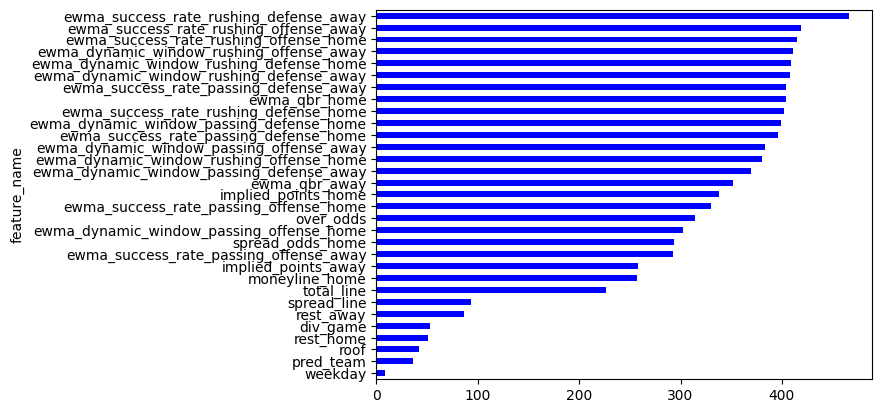

In [554]:
from matplotlib import pyplot as plt
feature_importances = score_model.named_steps['lgbmregressor'].feature_importances_
import_df = pd.DataFrame(zip(features,feature_importances),columns=['feature_name','feature_importance']).sort_values(by='feature_importance',ascending=True)

feature_imp = pd.Series(import_df['feature_importance'].values,index=import_df['feature_name'])
feature_imp.plot(kind='barh',color='blue')
plt.show()

In [555]:
print(f"Total win percentage: {100.0*results['total_win'].mean()}\nSpread win percentage: {100*results['spread_win'].mean()}")
results [['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score', 'away_score_pred', 'away_score', 
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'correct_spread_play', 'spread_win',
          'total_pred', 'total_line', 'true_total', 'total_play', 'correct_total_play', 'total_win']]

Total win percentage: 54.59317585301837
Spread win percentage: 48.058902275769746


,season,week,home_team,away_team,home_score_pred,home_score,away_score_pred,away_score,spread_pred,spread_line,true_spread,spread_play,correct_spread_play,spread_win,total_pred,total_line,true_total,total_play,correct_total_play,total_win
2192,2018,4,NE,MIA,28.458630,38.0,22.123626,7.0,-6.335004,-6.5,-31.0,MIA,NE,0.0,50.582257,50.5,45.0,over,under,0.0
1437,2015,7,LAC,LV,27.549384,29.0,20.125141,37.0,-7.424243,-3.5,8.0,LAC,LV,0.0,47.674525,48.0,66.0,under,over,0.0
2496,2019,7,DEN,KC,22.609420,6.0,24.252382,30.0,1.642962,3.0,24.0,DEN,KC,0.0,46.861802,49.5,36.0,under,under,1.0
1602,2015,21,DEN,CAR,17.030971,24.0,32.240127,10.0,15.209156,4.5,-14.0,CAR,DEN,0.0,49.271098,43.0,34.0,over,under,0.0
968,2013,12,GB,MIN,16.541062,26.0,18.116102,26.0,1.575039,-6.0,0.0,MIN,MIN,1.0,34.657164,44.5,52.0,under,over,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,2019,3,DAL,MIA,34.101813,31.0,14.466692,6.0,-19.635121,-22.0,-25.0,MIA,DAL,0.0,48.568505,46.5,37.0,over,under,0.0
1175,2014,8,DEN,LAC,37.628675,35.0,24.830361,21.0,-12.798315,-9.0,-14.0,DEN,DEN,1.0,62.459036,51.0,56.0,over,over,1.0
2704,2020,3,ATL,CHI,23.963938,26.0,22.744663,30.0,-1.219275,-2.5,4.0,CHI,CHI,1.0,46.708600,46.0,56.0,over,over,1.0
2817,2020,10,CHI,MIN,18.520659,13.0,24.401480,19.0,5.880821,3.5,6.0,MIN,MIN,1.0,42.922139,44.0,32.0,under,under,1.0


In [556]:
from scipy.stats import pointbiserialr

corr, _ = pointbiserialr(results["spread_win"], results["moneyline_home"])
print('Pearsons correlation: %.3f' % corr)

corr, _ = pointbiserialr(results["spread_win"], results["spread_diff"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: nan
Pearsons correlation: nan


# This week's plays

In [557]:
this_week = df[(df['season'] == current_year) & (df['week'] == current_week)]
#this_week = this_week[~this_week['home_score'].notnull()]

this_week_away_scores = score_model.predict_scores(this_week[input_features], 'away')
this_week_home_scores = score_model.predict_scores(this_week[features], 'home')

this_week['away_score_pred'] = this_week_away_scores
this_week['home_score_pred'] = this_week_home_scores

plays = scores_to_bets(this_week)


In [558]:

from sklearn.preprocessing import LabelEncoder

def win_probability(df, classifier, features):
    
    win_probs = classifier.predict_proba(df[features])[:, 1] * 100

    return win_probs

plays['spread_win_prob'] = win_probability(plays, classifier = spread_clf, features = spread_class_features)
plays['total_win_prob'] = win_probability(plays, classifier = total_clf, features = total_class_features)


In [559]:
def determine_plays(df):
    df = df.copy()

    max_spreads_plays = 5
    max_total_plays = 5
    
    # Determine the top n spread and total plays
    df['is_top_n_spread'] = df['spread_win_prob'].rank(method='first', ascending=False) <= max_spreads_plays
    df['is_top_n_total'] = df['total_win_prob'].rank(method='first', ascending=False) <= max_total_plays

    # Apply conditions to set spread_lock
    df['spread_lock'] = (
        df['is_top_n_spread'] &
        (abs(df['spread_pred'] - df['spread_line']) >= 0.5) &
        (df['spread_win_prob'] > 55.0)
    ).astype(int)

    df['total_lock'] = (
        df['is_top_n_total'] &
        (abs(df['total_pred'] - df['total_line']) >= 0.5) &
        (df['total_win_prob'] > 55.0)
    ).astype(int)
    
    # Drop the helper columns
    df.drop(['is_top_n_spread', 'is_top_n_total'], axis=1, inplace=True)
    
    return df

def print_plays(df):
    # Print Spread plays
    print("Spread plays:")
    spread_plays = df[df['spread_lock'] == 1]
    spread_plays = spread_plays.sort_values(by='spread_win_prob', ascending=False)
    for _, row in spread_plays.iterrows():
        mult = -1 if row['spread_play'] == row['away_team'] else 1
        pref = '+' if row['spread_line'] * mult > 0 else ''
        pref2 = '+' if row['spread_pred'] * mult > 0 else ''
        print(f"{row['home_team']}/{row['away_team']}: {row['spread_play']} {pref}{row['spread_line']*mult} "
              f"(model {row['spread_play']} {pref2}{(row['spread_pred']*mult):.2f}, "
              f"{row['spread_win_prob']:.2f}% win probability)")

    # Print Total plays
    print("\nTotal plays:")
    total_plays = df[df['total_lock'] == 1]
    total_plays = total_plays.sort_values(by='total_win_prob', ascending=False)
    for _, row in total_plays.iterrows():
        print(f"{row['home_team']}/{row['away_team']}: {row['total_play']} {row['total_line']} "
              f"(model {row['total_pred']:.2f}, {row['total_win_prob']:.2f}% win probability)")

plays = determine_plays(plays)

In [560]:
print_plays(plays)
plays[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
          'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob', 'spread_lock', 'total_pred', 'total_line', 'total_play', 'total_win_prob', 'total_lock']]

Spread plays:
TB/BAL: TB +3.5 (model TB +2.27, 85.66% win probability)
PIT/NYJ: PIT +1.5 (model PIT +0.89, 75.49% win probability)
NYG/PHI: NYG +3.0 (model NYG +1.10, 72.13% win probability)

Total plays:
SF/KC: under 47.0 (model 44.28, 74.00% win probability)
ARI/LAC: under 44.0 (model 43.34, 72.57% win probability)
BUF/TEN: over 41.5 (model 45.79, 64.44% win probability)
CLE/CIN: over 42.0 (model 45.63, 59.10% win probability)
TB/BAL: over 48.5 (model 51.75, 58.22% win probability)


,season,week,home_team,away_team,home_score_pred,away_score_pred,spread_pred,spread_line,spread_play,spread_win_prob,spread_lock,total_pred,total_line,total_play,total_win_prob,total_lock
3886,2024,7,NO,DEN,20.484935,17.025704,-3.459231,2.5,NO,41.610668,0,37.510640,37.0,over,38.897534,0
3887,2024,7,JAX,NE,24.603592,19.893092,-4.710501,-5.5,NE,46.158834,0,44.496684,42.5,over,51.237139,0
3888,2024,7,ATL,SEA,28.522465,25.514709,-3.007756,-3.0,ATL,70.195075,0,54.037173,51.0,over,48.962349,0
3889,2024,7,BUF,TEN,27.834368,17.957525,-9.876843,-8.5,BUF,45.172279,0,45.791892,41.5,over,64.442560,1
3890,2024,7,CLE,CIN,17.250125,28.378015,11.127891,6.5,CIN,66.149750,0,45.628140,42.0,over,59.101547,1
3891,2024,7,GB,HOU,24.633378,22.011320,-2.622058,-3.0,HOU,51.593195,0,46.644697,47.5,under,23.860482,0
3892,2024,7,IND,MIA,21.164794,19.809180,-1.355614,-3.0,MIA,45.832709,0,40.973975,44.0,under,31.614927,0
3893,2024,7,MIN,DET,21.305406,19.527448,-1.777958,-2.0,DET,83.087288,0,40.832854,50.0,under,38.886583,0
3894,2024,7,NYG,PHI,20.561389,21.657559,1.096169,3.0,NYG,72.129040,1,42.218948,43.0,under,38.857824,0
3895,2024,7,LA,LV,26.313479,18.668412,-7.645067,-6.5,LA,67.433750,0,44.981890,43.0,over,32.815411,0


In [566]:
def write_dynamo_picks(df, picks_table):
    for index, row in df.iterrows():
        picks_table.put_item(
            Item={
                'year_week': row['year_week'],
                'game_id': str(row['game_id']),
                'season': row['season'],
                'week': str(row['week']),  
                'home_team': row['home_team'],
                'away_team': row['away_team'],
                'home_score_pred': convert_to_decimal(row['home_score_pred']),
                'away_score_pred': convert_to_decimal(row['away_score_pred']),
                'spread_pred': convert_to_decimal(row['spread_pred']),
                'spread_line': convert_to_decimal(row['spread_line']),
                'spread_play': row['spread_play'],
                'spread_win_prob': convert_to_decimal(row['spread_win_prob']),
                'spread_lock': row['spread_lock'],
                'total_pred': convert_to_decimal(row['total_pred']),
                'total_line': convert_to_decimal(row['total_line']),
                'total_play': row['total_play'],
                'total_win_prob': convert_to_decimal(row['total_win_prob']),
                'total_lock': row['total_lock'],
                'date_time': row['date_time'],
                'write_time': datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
            }
        )

def write_dynamo_results(df, historical_results_table):
    for index, row in df.iterrows():
        historical_results_table.put_item(
            Item={
                'year_week': row['year_week'],
                'game_id': str(row['game_id']),
                'season': row['season'],
                'week': str(row['week']),
                'home_team': row['home_team'],
                'away_team': row['away_team'],
                'home_score_pred': convert_to_decimal(row['home_score_pred']),
                'away_score_pred': convert_to_decimal(row['away_score_pred']),
                'home_score': convert_to_decimal(row['home_score']),
                'away_score': convert_to_decimal(row['away_score']),
                'spread_pred': convert_to_decimal(row['spread_pred']),
                'spread_line': convert_to_decimal(row['spread_line']),
                'true_spread': convert_to_decimal(row['true_spread']),
                'spread_play': row['spread_play'],
                'spread_win_prob': convert_to_decimal(row['spread_win_prob']),
                'spread_lock': row['spread_lock'],
                'correct_spread_play': row['correct_spread_play'],
                'spread_win': None if math.isnan(row['spread_win']) else convert_to_decimal(row['spread_win']),
                'total_pred': convert_to_decimal(row['total_pred']),
                'total_line': convert_to_decimal(row['total_line']),
                'true_total': convert_to_decimal(row['true_total']),
                'total_play': row['total_play'],
                'total_win_prob': convert_to_decimal(row['total_win_prob']),
                'correct_total_play': row['correct_total_play'],
                'total_win': None if math.isnan(row['total_win']) else convert_to_decimal(row['total_win']),
                'total_lock': row['total_lock'],
                'date_time': row['date_time'],
                'write_time': datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
            }
        )

## Write picks to DB

In [569]:
# with open(f'src/nfl/nfl_expected_points/previous_models/score_model_{current_year_week}.pkl', 'wb') as f:
#     pickle.dump(score_model, f)



# picks_table = dynamodb.Table('nfl_expected_points_picks')
# historical_picks_table = dynamodb.Table('nfl_expected_points_historical_picks')


# write_dynamo_picks(plays, historical_picks_table)

# if len(plays)>5:
#     delete_dynamo_enteries(picks_table, {'PartitionKey': 'year_week', 'SortKey': 'game_id'})
#     write_dynamo_picks(plays, picks_table)

## Update model record

In [570]:
historical_picks_table = dynamodb.Table('nfl_expected_points_historical_picks')
historical_results_table = dynamodb.Table('nfl_expected_points_results')

historical_picks = historical_picks_table.scan().get('Items',[])
historical_results = historical_results_table.scan().get('Items',[])

picks_game_ids = {item['game_id'] for item in historical_picks}
results_game_ids = {item['game_id'] for item in historical_results}

no_results = list(picks_game_ids - results_game_ids)
print(f"Games not in picks that are in results (should be 0): {len(results_game_ids - picks_game_ids)}")
print(f"{len(no_results)} picks need to be updated")

Games not in picks that are in results (should be 0): 0
17 picks need to be updated


In [571]:
picks_to_update = pd.DataFrame([item for item in historical_picks if item['game_id'] in no_results])
#picks_to_update = pd.DataFrame([item for item in historical_picks])

scores = {
    row['game_id']: {'home_score': row['home_score'], 'away_score': row['away_score']}
    for _, row in df[['game_id', 'home_score', 'away_score']].iterrows()
    if pd.notna(row['home_score']) and pd.notna(row['away_score'])
}

picks_to_update = picks_to_update[picks_to_update['game_id'].isin(scores.keys())].copy()

picks_to_update['home_score'] = picks_to_update['game_id'].apply(lambda x: scores[x]['home_score'])
picks_to_update['away_score'] = picks_to_update['game_id'].apply(lambda x: scores[x]['away_score'])


picks_to_update = calculate_wins(picks_to_update)
check = get_result_stats(picks_to_update, Verbose = True)

print(f"Updating {len(picks_to_update)} picks")

Spread Win Percentage: 100.00%
Total Win Percentage: 50.00%

Spread Lock Win Percentage: 100.00%
Total Lock Win Percentage: 100.00%
Updating 2 picks


In [572]:
print(len(picks_to_update[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score',  'home_score_pred', 'away_score_pred',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob' , 'spread_lock', 
          'correct_spread_play', 'spread_win', 'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 
          'total_lock', 'correct_total_play', 'total_win', 'year_week','game_id','date_time']]))

picks_to_update[['home_team', 'away_team', 'home_score', 'away_score', 'home_score_pred', 'away_score_pred',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_lock', 
          'correct_spread_play', 'spread_win', 'total_pred', 'total_line', 'true_total', 'total_play', 
          'total_lock', 'correct_total_play', 'total_win']]

# need to add away score and away score preds

2


,home_team,away_team,home_score,away_score,home_score_pred,away_score_pred,spread_pred,spread_line,true_spread,spread_play,spread_lock,correct_spread_play,spread_win,total_pred,total_line,true_total,total_play,total_lock,correct_total_play,total_win
15,NYJ,BUF,20.0,23.0,13.335515827707525,24.49224253984985,11.156726712142326,1,3.0,BUF,0,BUF,1,37.82775836755738,41,43.0,under,0,over,0
16,NYG,CIN,7.0,17.0,18.249151398701652,25.198655553642396,6.949504154940744,4.5,10.0,CIN,1,CIN,1,43.44780695234405,46,24.0,under,1,under,1


In [573]:
#write_dynamo_results(picks_to_update, historical_results_table)



## # # #safety = dynamo_add_column(historical_results_table, df, 'away_score_pred', write_dynamo_results, delete_dynamo_enteries, {'PartitionKey': 'year_week', 'SortKey': 'game_id'})

# Results

In [514]:
historical_results_table = dynamodb.Table('nfl_expected_points_results')
results_df = pd.DataFrame(historical_results_table.scan()['Items'])

In [515]:
#results_df=results_df[results_df['week']=='5']
catch = get_result_stats(results_df, Verbose = True)

Spread Win Percentage: 48.31%
Total Win Percentage: 58.43%

Spread Lock Win Percentage: 51.85%
Total Lock Win Percentage: 64.29%


# Model retroactive record

In [517]:
def season_stats(df, current_week, year, score_pipeline):
    season_results = {}
    results_list = []
    for i in range(1,current_week+1):

        train_df = df[((df['season'] == year) & (df['week'] < i)) | (df['season'] < year)]
        train_df = train_df.dropna(subset = 'home_score', inplace=False)

        X = train_df[input_features]
        y = train_df[targets]   

        #do and eval split to fit classifiers
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        eval_results  = fit_eval(train_df, X_train, X_test, y_train, y_test, score_pipeline)
        spread_clf_temp, total_clf_temp = fit_classifiers(eval_results, spread_class_features, total_class_features)

        score_model_temp =  fit_score_model(X, y, score_pipeline)

        #predict this week
        test_df = df[(df['season'] == year) & (df['week'] == i)]
        X_test = test_df.loc[:, features]

        away_scores = score_model_temp.predict_scores(X_test[features], 'away')
        home_scores = score_model_temp.predict_scores(X_test[features], 'home')
        test_df['away_score_pred'] = away_scores
        test_df['home_score_pred'] = home_scores

        plays = scores_to_bets(test_df)
        plays['spread_win_prob'] = win_probability(plays, classifier = spread_clf, features = spread_class_features)
        plays['total_win_prob'] = win_probability(plays, classifier = total_clf, features = total_class_features)
        plays = determine_plays(plays)


        #get results
        results = calculate_wins(plays)
        data = get_result_stats(results, Verbose = False)

        

        season_results[i] = data
        season_results[i]['df'] = results

        results_list.append(results)
        
        print(f"Week {i} done")
        
    combined_results = pd.concat(results_list, ignore_index=True)    
    return season_results, combined_results

In [518]:
season_results,season_results_df = season_stats(df, current_week = 18, year = 2023, score_pipeline=score_pipeline)

total_spread_wins = sum(val['spread_wins'] for val in season_results.values())
total_total_wins = sum(val['total_wins'] for val in season_results.values())
total_games = sum(val['predicted_games'] for val in season_results.values())

total_spread_ratio = 100 * total_spread_wins / total_games
total_total_ratio = 100 * total_total_wins / total_games

total_spread_lock_wins = sum(val['spread_lock_wins'] for val in season_results.values())
total_total_lock_wins = sum(val['total_lock_wins'] for val in season_results.values())
total_spread_lock_games = sum(val['spread_lock_predictions'] for val in season_results.values())
total_total_lock_games = sum(val['total_lock_predictions'] for val in season_results.values())


total_spread_lock_ratio = 100* total_spread_lock_wins / total_spread_lock_games 
total_total_lock_ratio = 100 * total_total_lock_wins / total_total_lock_games

print(f"Season spread win percentage: {total_spread_ratio:.2f}%")
print(f"Season total win percentage: {total_total_ratio:.2f}%\n")
print(f"Season spread lock win percentage: {total_spread_lock_ratio:.2f}%")
print(f"Season total lock win percentage: {total_total_lock_ratio:.2f}%")

Week 1 done
Week 2 done
Week 3 done
Week 4 done
Week 5 done
Week 6 done
Week 7 done
Week 8 done
Week 9 done
Week 10 done
Week 11 done
Week 12 done
Week 13 done
Week 14 done
Week 15 done
Week 16 done
Week 17 done
Week 18 done
Season spread win percentage: 48.53%
Season total win percentage: 53.31%

Season spread lock win percentage: 52.05%
Season total lock win percentage: 54.55%


In [86]:
spread_clf.predict_proba(dd)

array([[0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375],
       [0.625, 0.375]])

In [87]:
dd

,ewma_dynamic_window_rushing_offense_home,ewma_dynamic_window_passing_offense_home,ewma_dynamic_window_rushing_defense_home,ewma_dynamic_window_passing_defense_home,ewma_dynamic_window_rushing_offense_away,ewma_dynamic_window_passing_offense_away,ewma_dynamic_window_rushing_defense_away,ewma_dynamic_window_passing_defense_away,ewma_success_rate_rushing_offense_home,ewma_success_rate_passing_offense_home,...,total_line,over_odds,away_rest,home_rest,div_game,home_implied_points,away_implied_points,ewma_qbr_home,ewma_qbr_away,spread_diff
3842,-0.157606,-0.026061,0.012841,-0.071982,0.009958,0.033201,0.041429,0.283080,0.441441,0.410707,...,45.0,-108.0,4,4,1,19.75,25.25,81.326002,96.011224,13.001783
3843,-0.188708,-0.017646,-0.029833,0.043422,-0.082435,0.245892,-0.134958,-0.156882,0.471592,0.469162,...,41.5,-108.0,7,7,1,22.00,19.50,97.824712,113.294250,2.157872
3844,-0.103842,-0.301423,-0.079911,0.062507,0.025262,0.063760,0.039260,0.120464,0.477127,0.357556,...,47.0,-112.0,6,7,0,21.25,25.75,97.000835,102.696328,13.426016
3845,-0.057295,-0.193315,-0.141989,-0.172318,-0.017527,0.075904,0.024801,0.235700,0.448558,0.389228,...,40.0,-115.0,7,7,0,21.50,18.50,66.485393,100.487331,7.079564
3846,0.013245,0.324106,-0.022836,-0.044889,-0.005043,-0.020670,-0.169458,-0.022042,0.540180,0.457198,...,44.0,-108.0,7,7,1,23.25,20.75,106.547703,95.764929,5.515124
3847,-0.267854,0.049834,-0.008154,-0.095332,0.012953,-0.110648,0.000311,0.122666,0.341923,0.419815,...,44.5,-112.0,6,7,1,25.00,19.50,99.111788,80.997226,18.195345
3848,0.006904,-0.129008,-0.125677,0.149776,-0.129151,0.048199,-0.172453,-0.098466,0.496990,0.378730,...,40.0,-110.0,7,7,0,18.75,21.25,69.899808,91.544806,1.103096
3849,-0.138040,-0.075377,-0.072660,-0.242856,-0.103097,-0.104400,-0.087428,-0.089146,0.437127,0.429433,...,39.5,-108.0,7,10,0,23.50,16.00,87.461477,67.176840,10.821855
3850,-0.089042,0.013896,0.006000,-0.035711,0.015991,0.035265,-0.002746,0.137888,0.441942,0.480833,...,42.0,-112.0,7,7,0,20.50,21.50,102.013415,84.824957,6.596071
3851,0.002598,0.078067,-0.029650,0.163954,0.044319,0.043586,0.010988,0.327342,0.451262,0.477485,...,49.0,-108.0,6,7,0,26.25,22.75,103.066114,111.949916,4.028977


In [75]:
season_results[1]['df']

,game_id,season,week,home_team,away_team,weekday,home_qb_id,away_qb_id,home_moneyline,spread_line,...,correct_total_play,total_win,spread_pct_diff,total_pct_diff,spread_diff,total_diff,spread_win_prob,total_win_prob,spread_lock,total_lock
3794,2024_01_BAL_KC,2024,1,KC,BAL,Thursday,00-0033873,00-0034796,-148.0,3.0,...,over,0,282.953400,2.247266,8.488602,1.033742,12.5,43.75,1,0
3795,2024_01_GB_PHI,2024,1,PHI,GB,Friday,00-0036389,00-0036264,-130.0,2.0,...,over,0,648.925633,1.504736,12.978513,0.744844,12.5,43.75,1,0
3796,2024_01_PIT_ATL,2024,1,ATL,PIT,Sunday,00-0029604,00-0036945,-192.0,4.0,...,under,0,267.407325,8.979896,10.696293,3.861355,12.5,43.75,1,0
3797,2024_01_ARI_BUF,2024,1,BUF,ARI,Sunday,00-0034857,00-0035228,-310.0,6.5,...,over,1,231.266575,12.561995,15.032327,5.778518,12.5,43.75,1,0
3798,2024_01_TEN_CHI,2024,1,CHI,TEN,Sunday,00-0039918,00-0039152,-198.0,4.0,...,under,0,285.769052,2.146202,11.430762,0.922867,12.5,43.75,1,0
3799,2024_01_NE_CIN,2024,1,CIN,NE,Sunday,00-0036442,00-0033119,-375.0,8.0,...,under,0,151.024819,7.993895,12.081986,3.237527,12.5,43.75,0,0
3800,2024_01_HOU_IND,2024,1,IND,HOU,Sunday,00-0039164,00-0039163,130.0,-3.0,...,over,0,-137.684213,8.092041,4.130526,3.965100,12.5,43.75,0,0
3801,2024_01_JAX_MIA,2024,1,MIA,JAX,Sunday,00-0036212,00-0036971,-180.0,3.5,...,under,1,108.552252,2.549662,3.799329,1.262083,12.5,43.75,0,0
3802,2024_01_CAR_NO,2024,1,NO,CAR,Sunday,00-0031280,00-0039150,-192.0,3.5,...,over,1,279.303161,1.329455,9.775611,0.551724,12.5,43.75,0,0
3803,2024_01_MIN_NYG,2024,1,NYG,MIN,Sunday,00-0035710,00-0034869,-105.0,-1.0,...,under,1,-40.768028,1.282438,0.407680,0.545036,12.5,43.75,0,0


In [76]:
win_probability(season_results[1]['df'], classifier = total_clf, features = total_class_features)

array([68.75, 68.75, 68.75, 68.75, 68.75, 68.75, 68.75, 68.75, 68.75,
       68.75, 68.75, 68.75, 68.75, 68.75, 68.75, 68.75])

In [74]:
season_results[1]['df'][spread_class_features]

,ewma_dynamic_window_rushing_offense_home,ewma_dynamic_window_passing_offense_home,ewma_dynamic_window_rushing_defense_home,ewma_dynamic_window_passing_defense_home,ewma_dynamic_window_rushing_offense_away,ewma_dynamic_window_passing_offense_away,ewma_dynamic_window_rushing_defense_away,ewma_dynamic_window_passing_defense_away,ewma_success_rate_rushing_offense_home,ewma_success_rate_passing_offense_home,...,total_line,over_odds,away_rest,home_rest,div_game,home_implied_points,away_implied_points,ewma_qbr_home,ewma_qbr_away,spread_diff
3794,-0.107190,0.083083,-0.038199,-0.097446,0.012443,0.119835,-0.149126,-0.096432,0.433810,0.478138,...,46.0,-110.0,7,7,0,24.50,21.50,98.835294,110.383436,8.488602
3795,-0.068745,0.019491,0.048622,0.150730,-0.043660,0.350020,0.025572,0.045650,0.512234,0.468101,...,49.5,-108.0,7,7,0,25.75,23.75,83.484101,111.866798,12.978513
3796,-0.167626,-0.053773,-0.115980,0.054958,-0.076085,-0.007372,-0.091640,-0.001303,0.464706,0.452607,...,43.0,-105.0,7,7,0,23.50,19.50,103.892098,87.811779,10.696293
3797,0.083014,0.099025,0.024722,-0.067034,0.068197,-0.019998,-0.007782,0.234700,0.576772,0.497546,...,46.0,-108.0,7,7,0,26.25,19.75,92.458386,96.399007,15.032327
3798,0.006875,-0.091334,-0.121228,-0.047740,-0.070997,-0.067510,-0.130950,0.078303,0.480437,0.403013,...,43.0,-110.0,7,7,0,23.50,19.50,76.668601,76.578369,11.430762
3799,-0.077674,0.034105,-0.015802,0.044261,-0.115614,-0.338600,-0.207356,-0.124303,0.481195,0.460479,...,40.5,-108.0,7,7,0,24.25,16.25,97.893750,92.784847,12.081986
3800,-0.079151,0.021660,-0.075091,0.096941,-0.197612,0.083129,-0.090727,-0.063354,0.475380,0.413632,...,49.0,-108.0,7,7,1,23.00,26.00,88.279757,106.972031,4.130526
3801,-0.046544,0.020799,-0.135528,0.160843,-0.139771,0.001037,-0.033664,-0.038417,0.457048,0.436065,...,49.5,-108.0,7,7,0,26.50,23.00,87.176998,85.011096,3.799329
3802,-0.117552,0.146618,-0.239188,-0.066741,-0.080143,-0.321693,-0.063779,0.015033,0.439640,0.480175,...,41.5,-108.0,7,7,1,22.50,19.00,112.886248,73.622747,9.775611
3803,-0.126811,-0.080258,0.050968,-0.090137,-0.065740,-0.086105,-0.082987,0.112623,0.425552,0.390334,...,42.5,-112.0,7,7,0,20.75,21.75,75.140444,77.505721,0.407680


In [66]:
get_result_stats(season_results_df, Verbose=True)

Spread Win Percentage: 34.38%
Total Win Percentage: 50.00%

Spread Lock Win Percentage: 30.00%
Total Lock Win Percentage: 100.00%


{'predicted_games': 64,
 'spread_wins': 22,
 'spread_losses': 42,
 'spread_pushes': 0,
 'spread_win_pct': 34.375,
 'spread_lock_predictions': 20,
 'spread_lock_wins': 6,
 'spread_lock_losses': 14,
 'spread_lock_pushes': 0,
 'spread_lock_win_pct': 30.0,
 'total_wins': 32,
 'total_losses': 32,
 'total_pushes': 0,
 'total_win_pct': 50.0,
 'total_lock_predictions': 5,
 'total_lock_wins': 5,
 'total_lock_losses': 0,
 'total_lock_pushes': 0,
 'total_lock_win_pct': 100.0}

In [60]:
season_results_df[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob' , 'spread_lock', 
          'correct_spread_play', 'spread_win', 'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 
          'total_lock', 'correct_total_play', 'total_win', 'year_week','game_id','date_time']]

,season,week,home_team,away_team,home_score_pred,home_score,spread_pred,spread_line,true_spread,spread_play,...,total_line,true_total,total_play,total_win_prob,total_lock,correct_total_play,total_win,year_week,game_id,date_time
0,2024,1,KC,BAL,25.227430,27.0,-5.488602,3.0,-7.0,BAL,...,46.0,47.0,under,43.75,0,over,0,2024_1,2024_01_BAL_KC,2024-09-05-20:20
1,2024,1,PHI,GB,29.866834,34.0,-10.978513,2.0,-5.0,GB,...,49.5,63.0,under,43.75,0,over,0,2024_1,2024_01_GB_PHI,2024-09-06-20:15
2,2024,1,ATL,PIT,26.778824,10.0,-6.696293,4.0,8.0,PIT,...,43.0,28.0,over,43.75,0,under,0,2024_1,2024_01_PIT_ATL,2024-09-08-13:00
3,2024,1,BUF,ARI,30.155423,34.0,-8.532327,6.5,-6.0,ARI,...,46.0,62.0,over,43.75,0,over,1,2024_1,2024_01_ARI_BUF,2024-09-08-13:00
4,2024,1,CHI,TEN,25.676814,24.0,-7.430762,4.0,-7.0,TEN,...,43.0,41.0,over,43.75,0,under,0,2024_1,2024_01_TEN_CHI,2024-09-08-13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024,4,LAC,KC,20.068817,10.0,3.475934,-7.5,7.0,LAC,...,41.5,27.0,over,68.75,0,under,0,2024_4,2024_04_KC_LAC,2024-09-29-16:25
60,2024,4,LV,CLE,21.620181,20.0,-1.263130,-2.5,-4.0,LV,...,36.5,36.0,over,68.75,0,under,0,2024_4,2024_04_CLE_LV,2024-09-29-16:25
61,2024,4,BAL,BUF,24.073055,35.0,1.541068,2.5,-25.0,BUF,...,46.5,45.0,over,68.75,0,under,0,2024_4,2024_04_BUF_BAL,2024-09-29-20:20
62,2024,4,MIA,TEN,21.512425,12.0,-5.182915,2.5,19.0,TEN,...,37.0,43.0,over,68.75,0,over,1,2024_4,2024_04_TEN_MIA,2024-09-30-19:30


In [245]:
check_week = 2
print(f"Week {check_week} spread win percentage: {season_results[check_week]['spread_perc']:.2f}%")
print(f"Week {check_week} total win percentage: {season_results[check_week]['total_perc']:.2f}%\n")
print(f"Week {check_week} spread lock win percentage: {season_results[check_week]['spread_lock_perc']:.2f}%")
print(f"Week {check_week} total lock win percentage: {season_results[check_week]['total_lock_perc']:.2f}%")

Week 2 spread win percentage: 56.25%
Week 2 total win percentage: 68.75%

Week 2 spread lock win percentage: 60.00%
Week 2 total lock win percentage: 100.00%


In [246]:
season_results[4]['df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob' , 'correct_spread_play', 'spread_win',
          'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 'correct_total_play', 'total_win']]

,season,week,home_team,away_team,home_score_pred,home_score,spread_pred,spread_line,true_spread,spread_play,spread_win_prob,correct_spread_play,spread_win,total_pred,total_line,true_total,total_play,total_win_prob,correct_total_play,total_win
3842,2024,4,NYG,DAL,16.703344,15.0,-8.693796,-5.5,-5.0,DAL,45.600235,NYG,0,42.100485,45.0,35.0,under,58.868575,under,1
3843,2024,4,ATL,NO,22.848740,26.0,-2.535837,2.5,2.0,NO,54.416106,NO,1,48.233317,41.5,50.0,over,70.762942,over,1
3844,2024,4,CAR,CIN,23.333920,24.0,-6.556497,-4.5,-10.0,CIN,57.167352,CIN,1,53.224338,47.0,58.0,over,82.164559,over,1
3845,2024,4,CHI,LA,22.029294,24.0,1.401981,3.0,6.0,LA,54.019234,CHI,0,42.656608,40.0,42.0,over,70.451877,over,1
3846,2024,4,GB,MIN,22.140346,29.0,3.502799,2.5,-2.0,GB,47.330288,MIN,0,40.777893,44.0,60.0,under,51.475143,over,0
3847,2024,4,HOU,JAX,32.486968,24.0,14.257919,5.5,4.0,HOU,70.599947,JAX,0,50.716016,44.5,44.0,over,65.536666,under,0
3848,2024,4,IND,PIT,20.448996,27.0,-0.664179,-2.5,3.0,IND,39.754149,IND,1,41.562171,40.0,51.0,over,40.380344,over,1
3849,2024,4,NYJ,DEN,23.941120,9.0,6.270982,7.5,-1.0,DEN,55.636431,DEN,1,41.611259,39.5,19.0,over,74.281007,under,0
3850,2024,4,TB,PHI,19.532987,33.0,-2.563405,-1.0,17.0,PHI,63.511029,TB,0,41.629379,42.0,49.0,under,41.760528,over,0
3851,2024,4,ARI,WAS,29.463173,14.0,6.123964,3.5,-28.0,ARI,52.395994,WAS,0,52.802383,49.0,56.0,over,51.963119,over,1


In [247]:
season_results[check_week]['spread_locks_df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score', 'away_score_pred', 'away_score', 
           'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob', 'correct_spread_play', 'spread_win']]

,season,week,home_team,away_team,home_score_pred,home_score,away_score_pred,away_score,spread_pred,spread_line,true_spread,spread_play,spread_win_prob,correct_spread_play,spread_win
3823,2024,2,KC,CIN,30.525110,26.0,20.950213,25.0,9.574897,6.5,1.0,KC,75.578087,CIN,0
3818,2024,2,NE,SEA,23.747448,20.0,18.202450,23.0,5.544999,-3.5,-3.0,NE,71.541541,NE,1
3813,2024,2,DAL,NO,26.250288,19.0,21.051116,44.0,5.199172,6.5,-25.0,NO,70.140165,NO,1
3824,2024,2,HOU,CHI,22.157520,19.0,18.807480,13.0,3.350039,6.0,6.0,CHI,65.364079,HOU,0
3822,2024,2,DEN,PIT,17.949088,6.0,23.725234,13.0,-5.776146,-3.0,-7.0,PIT,63.329542,PIT,1


In [248]:
season_results[check_week]['total_locks_df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score', 'away_score_pred', 'away_score', 
          'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 'correct_total_play', 'total_win', 'spread_play']]

,season,week,home_team,away_team,home_score_pred,home_score,away_score_pred,away_score,total_pred,total_line,true_total,total_play,total_win_prob,correct_total_play,total_win,spread_play
3812,2024,2,CAR,LAC,15.252023,3.0,18.798629,26.0,34.050651,39.0,29.0,under,85.812429,under,1,CAR
3818,2024,2,NE,SEA,23.747448,20.0,18.202450,23.0,41.949898,39.0,43.0,over,80.852127,over,1,NE
3815,2024,2,GB,IND,18.880204,16.0,20.379963,10.0,39.260166,41.5,26.0,under,78.208741,under,1,GB
3810,2024,2,MIA,BUF,23.250958,10.0,22.976148,31.0,46.227106,48.5,41.0,under,74.234750,under,1,BUF
3821,2024,2,ARI,LA,24.029983,41.0,26.815601,10.0,50.845584,47.5,51.0,over,72.735954,over,1,LA


In [249]:
# season_results[3]['df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
#           'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob',
#           'total_pred', 'total_line', 'total_play', 'total_win_prob', 
#           'spread_win','total_win']].to_csv('my_data.csv', index=False)

# Supplemental analytics and vizualizations

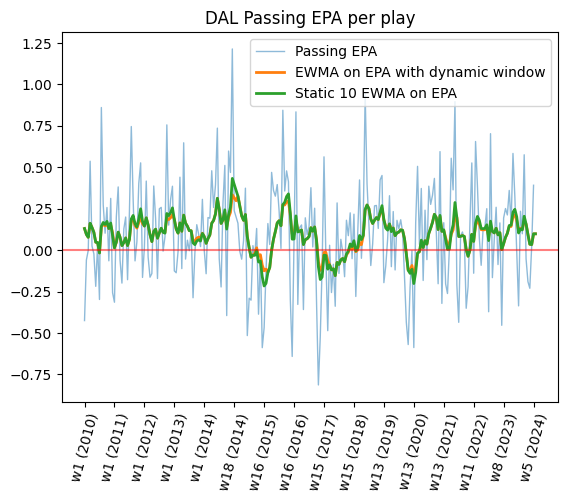

In [251]:
team = 'DAL'
tm = epa.loc[epa['team'] == team, :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title(f'{team} Passing EPA per play')
plt.show()

### 2023 Season - EPA

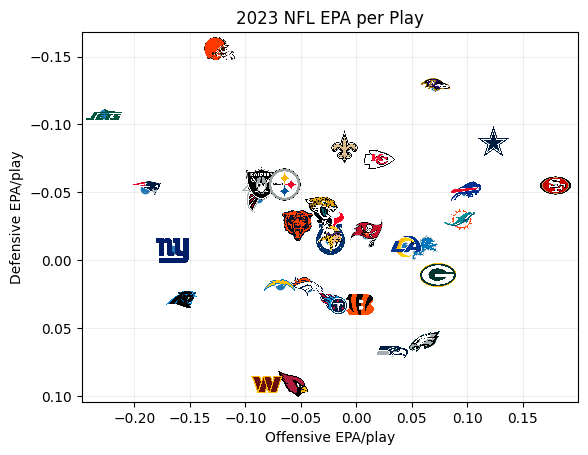

In [870]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


# Assuming nflreadr::load_pbp(2020) loads a pandas DataFrame
pbp_viz = pbp[(pbp['season'] == 2023) & (pbp['season_type'] == 'REG') & (pbp['posteam'].notna()) & ((pbp['rush'] == 1) | (pbp['pass'] == 1))] #(pbp['rz'] == 1) &

offense = pbp_viz.groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_epa'})
pass_offense = pbp_viz[pbp_viz['pass_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_pass_epa'})
run_offense = pbp_viz[pbp_viz['rush_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_run_epa'})
rz_offense =pbp_viz[pbp_viz['rz']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'rz_off_epa'})
non_rz_offense=pbp_viz[pbp_viz['rz']==0].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'non_rz_off_epa'})



defense = pbp_viz.groupby('defteam').agg({'epa': np.mean}).reset_index().rename(columns={'defteam': 'team', 'epa': 'def_epa'})

combined = pd.merge(offense, defense, on='team')

qbs = pbp_viz[(pbp_viz['pass'] == 1) | (pbp_viz['rush'] == 1) & pbp_viz['down'].isin(range(1, 5))].groupby('id').agg({
    'name': 'first',
    'posteam': 'last',
    'id': 'count',
    'qb_epa': np.mean
}).rename(columns={'id': 'plays', 'posteam': 'team'}).query('plays > 200').nlargest(10, 'qb_epa')

# Assuming that 'team_logos' is a dictionary with team names as keys and URLs/paths of logos as values
team_logos = teams.set_index('team_abbr')['team_logo_espn'].to_dict()

fig, ax = plt.subplots()
ax.scatter(combined['off_epa'], combined['def_epa'])

for x, y, team in zip(combined['off_epa'], combined['def_epa'], combined['team']):

    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    
    # Adjust zoom size only for Jets and Packers
    if team in ['NYJ', 'GB']:  # Adjust based on the correct team abbreviation in your dataset
        zoom_factor = 0.007  # Smaller size for Jets and Packers
    else:
        zoom_factor = 0.05  # Default size for other teams
    
    # Create offset image with the appropriate zoom
    oi = OffsetImage(img, zoom=zoom_factor)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Offensive EPA/play')
ax.set_ylabel('Defensive EPA/play')
ax.set_title('2023 NFL EPA per Play')
ax.grid(alpha=0.2)
ax.invert_yaxis()
plt.show()

### Model sees - Offense EPA

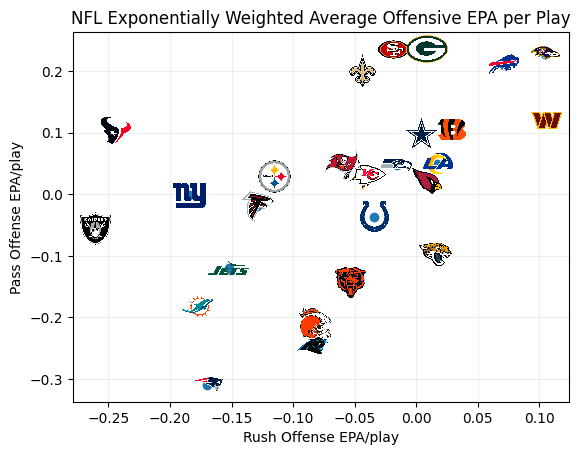

In [883]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


m = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
m1 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_away'], value_name='ewma_rushing_offense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_rushing_offense']]
m2 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_passing_offense_home', 'ewma_dynamic_window_passing_offense_away'], value_name='ewma_passing_offense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_passing_offense']]
combined = pd.concat([m, m1['ewma_rushing_offense'], m2['ewma_passing_offense']], axis=1)

fig, ax = plt.subplots()
ax.scatter(combined['ewma_rushing_offense'], combined['ewma_passing_offense'])

# Add logos to the plot
for x, y, team in zip(combined['ewma_rushing_offense'], combined['ewma_passing_offense'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    
    # Adjust zoom size only for Jets and Packers
    if team in ['NYJ', 'GB']:  # Adjust based on the correct team abbreviation in your dataset
        zoom_factor = 0.008  # Smaller size for Jets and Packers
    else:
        zoom_factor = 0.05  # Default size for other teams
    
    # Create offset image with the appropriate zoom
    oi = OffsetImage(img, zoom=zoom_factor)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Rush Offense EPA/play')
ax.set_ylabel('Pass Offense EPA/play')
ax.set_title('NFL Exponentially Weighted Average Offensive EPA per Play')
ax.grid(alpha=0.2)
#ax.invert_yaxis()
plt.show()

### Model sees - Defense EPA

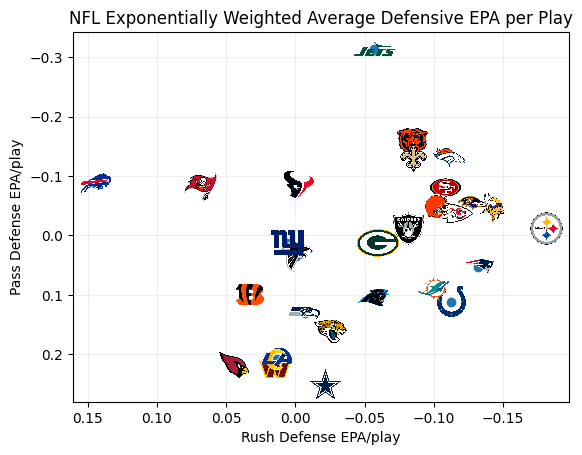

In [882]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


m = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
m1 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_away'], value_name='ewma_rushing_defense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_rushing_defense']]
m2 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_passing_defense_home', 'ewma_dynamic_window_passing_defense_away'], value_name='ewma_passing_defense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_passing_defense']]
combined = pd.concat([m, m1['ewma_rushing_defense'], m2['ewma_passing_defense']], axis=1)
fig, ax = plt.subplots()
ax.scatter(combined['ewma_rushing_defense'], combined['ewma_passing_defense'])

# Add logos to the plot
for x, y, team in zip(combined['ewma_rushing_defense'], combined['ewma_passing_defense'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    
    # Adjust zoom size only for Jets and Packers
    if team in ['NYJ', 'GB', 'PHI']:  # Adjust based on the correct team abbreviation in your dataset
        zoom_factor = 0.008  # Smaller size for Jets and Packers
    else:
        zoom_factor = 0.05  # Default size for other teams
    
    # Create offset image with the appropriate zoom
    oi = OffsetImage(img, zoom=zoom_factor)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Rush Defense EPA/play')
ax.set_ylabel('Pass Defense EPA/play')
ax.set_title('NFL Exponentially Weighted Average Defensive EPA per Play')
ax.grid(alpha=0.2)
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

### 2023 Season - RZ Offense and Defense EPA

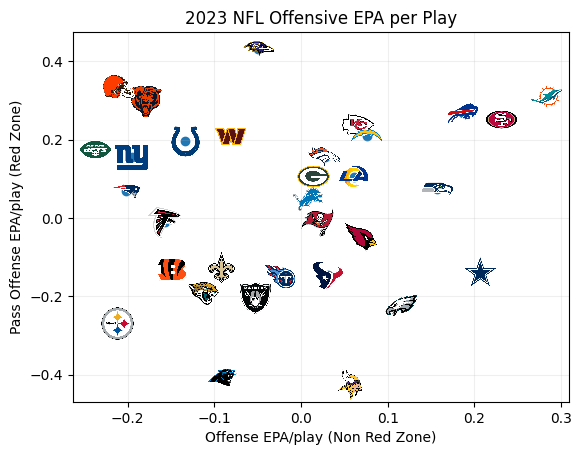

In [842]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


# Assuming nflreadr::load_pbp(2020) loads a pandas DataFrame
pbp_viz = pbp[(pbp['season'] == 2023) & (pbp['season_type'] == 'REG') & (pbp['posteam'].notna()) & ((pbp['rush'] == 1) | (pbp['pass'] == 1))] #(pbp['rz'] == 1) &

offense = pbp_viz.groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_epa'})
pass_offense = pbp_viz[pbp_viz['pass_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_pass_epa'})
run_offense = pbp_viz[pbp_viz['rush_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_run_epa'})
rz_offense =pbp_viz[pbp_viz['rz']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'rz_off_epa'})
non_rz_offense=pbp_viz[pbp_viz['rz']==0].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'non_rz_off_epa'})



defense = pbp_viz.groupby('defteam').agg({'epa': np.mean}).reset_index().rename(columns={'defteam': 'team', 'epa': 'def_epa'})

combined = pd.merge(rz_offense, non_rz_offense, on='team')

qbs = pbp_viz[(pbp_viz['pass'] == 1) | (pbp_viz['rush'] == 1) & pbp_viz['down'].isin(range(1, 5))].groupby('id').agg({
    'name': 'first',
    'posteam': 'last',
    'id': 'count',
    'qb_epa': np.mean
}).rename(columns={'id': 'plays', 'posteam': 'team'}).query('plays > 200').nlargest(10, 'qb_epa')

# Assuming that 'team_logos' is a dictionary with team names as keys and URLs/paths of logos as values
team_logos = teams.set_index('team_abbr')['team_logo_espn'].to_dict()

fig, ax = plt.subplots()
ax.scatter(combined['non_rz_off_epa'], combined['rz_off_epa'])

# Add logos to the plot
for x, y, team in zip(combined['non_rz_off_epa'], combined['rz_off_epa'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Offense EPA/play (Non Red Zone)')
ax.set_ylabel('Offense EPA/play (Red Zone)')
ax.set_title('2023 NFL Offensive EPA per Play')
ax.grid(alpha=0.2)
#ax.invert_yaxis()
plt.show()

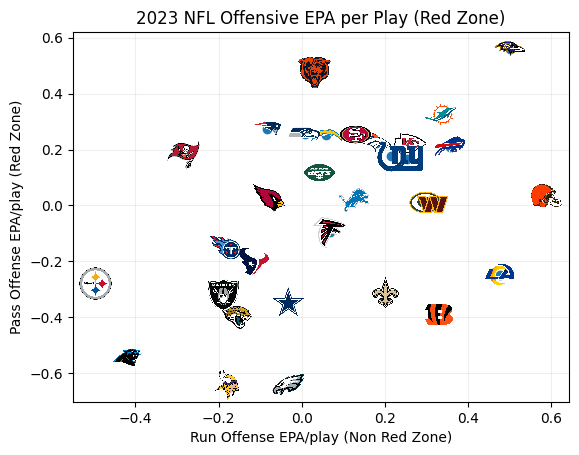

In [843]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


# Assuming nflreadr::load_pbp(2020) loads a pandas DataFrame
pbp_viz = pbp[(pbp['rz'] == 1) & (pbp['season'] == 2023) & (pbp['season_type'] == 'REG') & (pbp['posteam'].notna()) & ((pbp['rush'] == 1) | (pbp['pass'] == 1))] #(pbp['rz'] == 1) &

offense = pbp_viz.groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_epa'})
pass_offense = pbp_viz[pbp_viz['pass_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_pass_epa'})
run_offense = pbp_viz[pbp_viz['rush_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_run_epa'})
rz_offense =pbp_viz[pbp_viz['rz']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'rz_off_epa'})
non_rz_offense=pbp_viz[pbp_viz['rz']==0].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'non_rz_off_epa'})



defense = pbp_viz.groupby('defteam').agg({'epa': np.mean}).reset_index().rename(columns={'defteam': 'team', 'epa': 'def_epa'})

combined = pd.merge(run_offense, pass_offense, on='team')

qbs = pbp_viz[(pbp_viz['pass'] == 1) | (pbp_viz['rush'] == 1) & pbp_viz['down'].isin(range(1, 5))].groupby('id').agg({
    'name': 'first',
    'posteam': 'last',
    'id': 'count',
    'qb_epa': np.mean
}).rename(columns={'id': 'plays', 'posteam': 'team'}).query('plays > 200').nlargest(10, 'qb_epa')

# Assuming that 'team_logos' is a dictionary with team names as keys and URLs/paths of logos as values
team_logos = teams.set_index('team_abbr')['team_logo_espn'].to_dict()

fig, ax = plt.subplots()
ax.scatter(combined['off_run_epa'], combined['off_pass_epa'])

# Add logos to the plot
for x, y, team in zip(combined['off_run_epa'], combined['off_pass_epa'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Run Offense EPA/play (Non Red Zone)')
ax.set_ylabel('Pass Offense EPA/play (Red Zone)')
ax.set_title('2023 NFL Offensive EPA per Play (Red Zone)')
ax.grid(alpha=0.2)
#ax.invert_yaxis()
plt.show()

In [4]:
data_1 = [
    {
        "date": "2024-10-16",
        "player_name": "Andrew Nembhard",
        "sportsbook": "BetRivers",
        "odds": 1300.0,
        "units": 80.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Andrew Wiggins",
        "sportsbook": "BetMGM",
        "odds": 900.0,
        "units": 108.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Austin Reaves",
        "sportsbook": "BetRivers",
        "odds": 1200.0,
        "units": 59.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Caleb Houstan",
        "sportsbook": "BetMGM",
        "odds": 1400.0,
        "units": 58.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Cody Martin",
        "sportsbook": "BetRivers",
        "odds": 1200.0,
        "units": 53.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "D'Angelo Russell",
        "sportsbook": "BetRivers",
        "odds": 1050.0,
        "units": 51.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Gary Harris",
        "sportsbook": "BetMGM",
        "odds": 1200.0,
        "units": 75.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Jalen Suggs",
        "sportsbook": "DraftKings",
        "odds": 1100.0,
        "units": 92.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Julian Champagnie",
        "sportsbook": "BetMGM",
        "odds": 1250.0,
        "units": 88.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Kris Murray",
        "sportsbook": "BetMGM",
        "odds": 1150.0,
        "units": 82.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Max Strus",
        "sportsbook": "BetMGM",
        "odds": 950.0,
        "units": 64.0,
        "bankroll": 5000
    },
    {
        "date": "2024-10-16",
        "player_name": "Wendell Carter Jr.",
        "sportsbook": "DraftKings",
        "odds": 800.0,
        "units": 53.0,
        "bankroll": 5000
    }
]